<h1><center><b> EE511 Project: Human Activity Recognition using CNN and LSTM</center></h1></b>

##<b> Team Members:</b>

        1) Monark Bandishbhai Parekh           mparekh2@asu.edu            1222179426
        2) Siddahant Jain                      sjain198@asu.edu            1223151020
        3) Dhiram Ashok Buch                   dbuch@asu.edu               1221194052
        4) Hir Gandhi                          hgandhi3@asu.edu            1219831314

##<b> Importing all the necessary libraries</b> 

In [15]:
# Importing Libraries
import tensorflow as tf
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

##<b>Ensuring Data is Properly Loaded (Own contribution)</b>

In [16]:
# Reading the Raw Data File after Uploading it in the 'content' folder
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv(r'/content/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
print(df_har.head())
df_har = df_har.dropna()
print(df_har.shape)

   user activity       timestamp    x-axis     y-axis        z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;
(1098203, 6)


In [17]:
df_har.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 58.7+ MB


##<b>Balancing the Dataset  </b>
The columns we will be most interested in are activity, x-axis, y-axis and z-axis. 



In [18]:
# Transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))

In [19]:
# Dropping Rows where 'timestamp' is 0
df = df_har[df_har['timestamp'] != 0]

In [20]:
# Arranging the Data in Ascending Order of 'user' and 'timestamp'
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

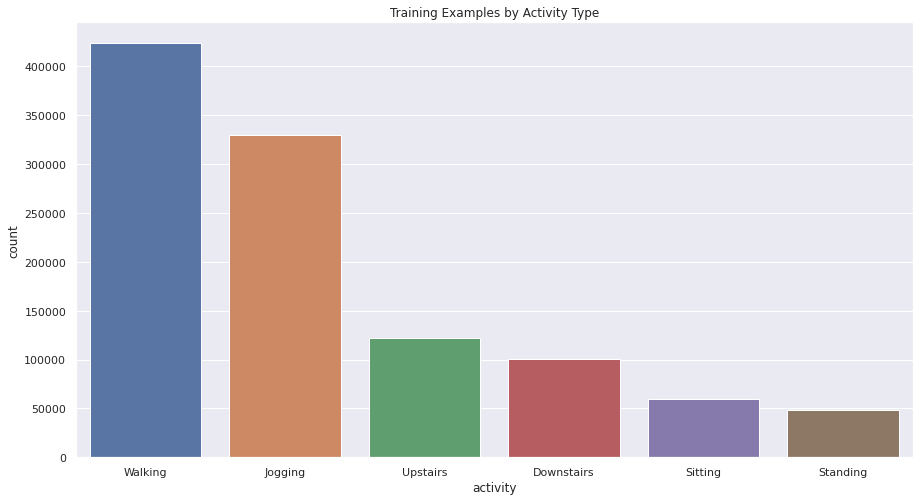

In [21]:
# Analyzing Class Label Distribution (Own contribution)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'activity', data = df)
plt.title('Training Examples by Activity Type')
plt.show()

##<b> Data Visualization for the Number of Samples Belonging to Each User (Own contribution)</b>



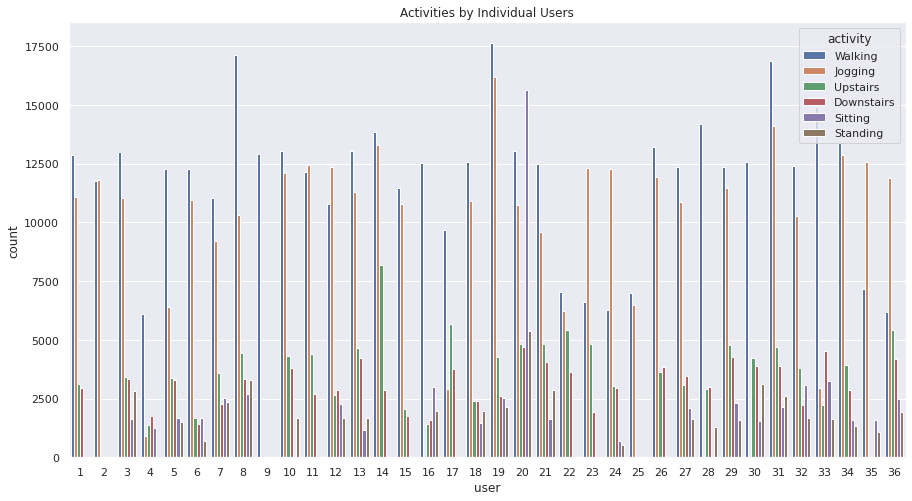

In [22]:
# Exploring the ways in which the Individual 'users' are Contributing to each 'activity'.
sns.countplot(x = 'user',  hue = 'activity', data = df)
plt.title('Activities by Individual Users')
plt.show()

##<b> Accelerometer Data Visualization </b>




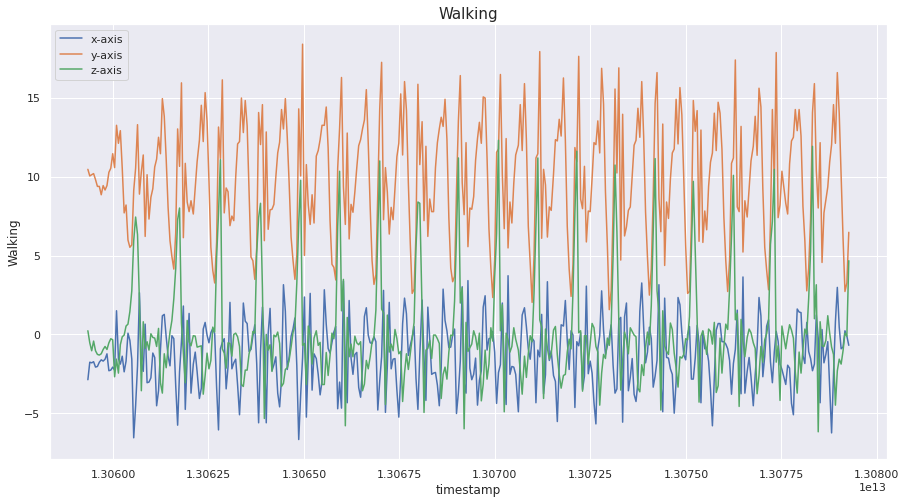

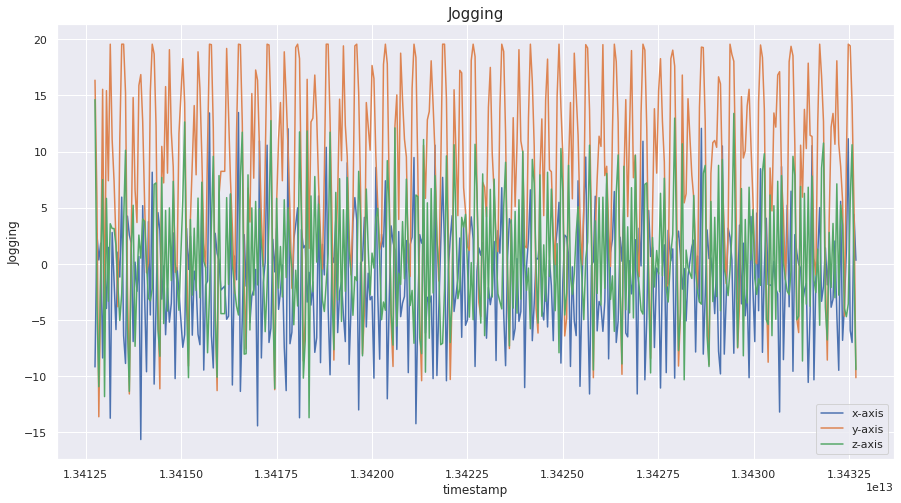

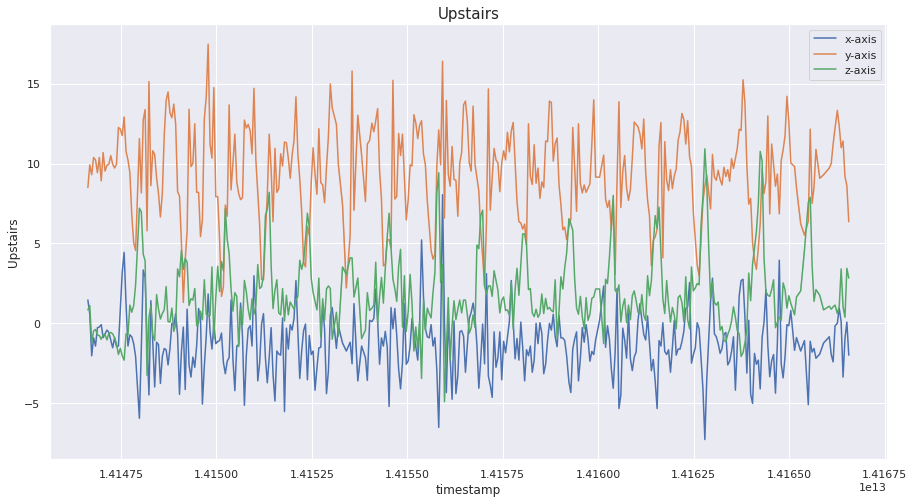

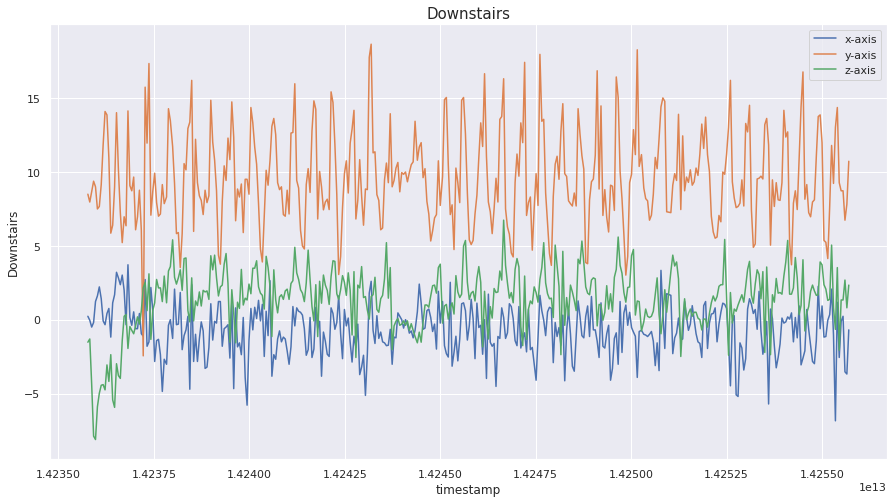

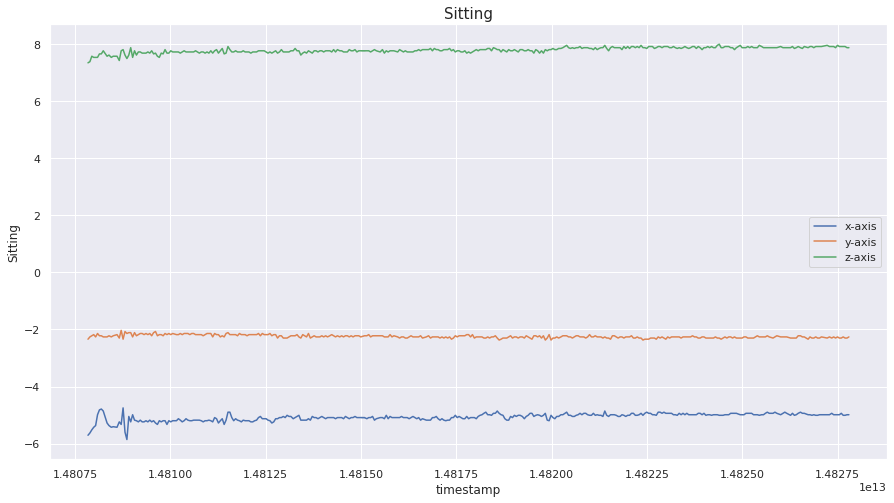

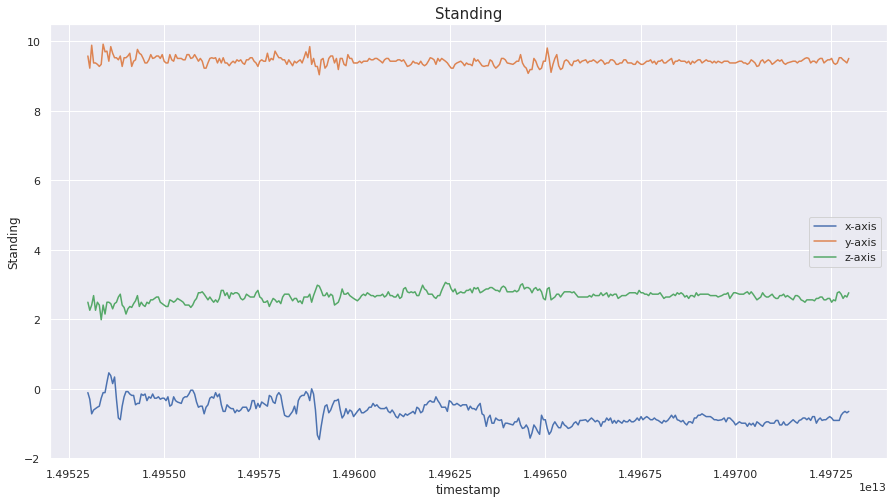

In [23]:
# Visualizing the ways in which the Signal Values in each of the x, y, and z Dimensions vary with time.
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
for i in activities:
    data36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()


##<b> Data Pre-Processing (Own contribution) </b>

In [24]:
# Initializing various model Parameters 
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 10
batch_size = 2000
learning_rate = 0.025
l2_loss = 0.0015

import scipy
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):

    xs = df['x-axis'].values[i: i + 50]

    ys = df['y-axis'].values[i: i + 50]

    zs = df['z-axis'].values[i: i + 50]

    label = scipy.stats.mode(df['activity'][i: i + 50])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

In [25]:
# Reshaping the Segments from a list of arrays to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

##<b> LSTM Model Our implementation, but we took reference from the paper.
 </b>

In [26]:
# Preparing the LSTM Model
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

# Building Model Architecture

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________
None


##<b> Training the LSTM Model </b>

In [27]:
# Model Training & Evaluation
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/10
35/35 [==============================] - 50s 1s/step - loss: 1.2087 - accuracy: 0.5612 - val_loss: 0.7315 - val_accuracy: 0.7368
Epoch 2/10
35/35 [==============================] - 48s 1s/step - loss: 0.6360 - accuracy: 0.7841 - val_loss: 0.5458 - val_accuracy: 0.8058
Epoch 3/10
35/35 [==============================] - 48s 1s/step - loss: 0.5368 - accuracy: 0.8101 - val_loss: 0.4918 - val_accuracy: 0.8177
Epoch 4/10
35/35 [==============================] - 48s 1s/step - loss: 0.4841 - accuracy: 0.8242 - val_loss: 0.4560 - val_accuracy: 0.8311
Epoch 5/10
35/35 [==============================] - 48s 1s/step - loss: 0.4548 - accuracy: 0.8319 - val_loss: 0.4291 - val_accuracy: 0.8367
Epoch 6/10
35/35 [==============================] - 48s 1s/step - loss: 0.4258 - accuracy: 0.8403 - val_loss: 0.4029 - val_accuracy: 0.8459
Epoch 7/10
35/35 [==============================] - 48s 1s/step - loss: 0.3956 - accuracy: 0.8502 - val_loss: 0.3868 - val_accuracy: 0.8529
Epoch 8/10
35/35 [==

##<b>Plots of Evalution Conditions </b>

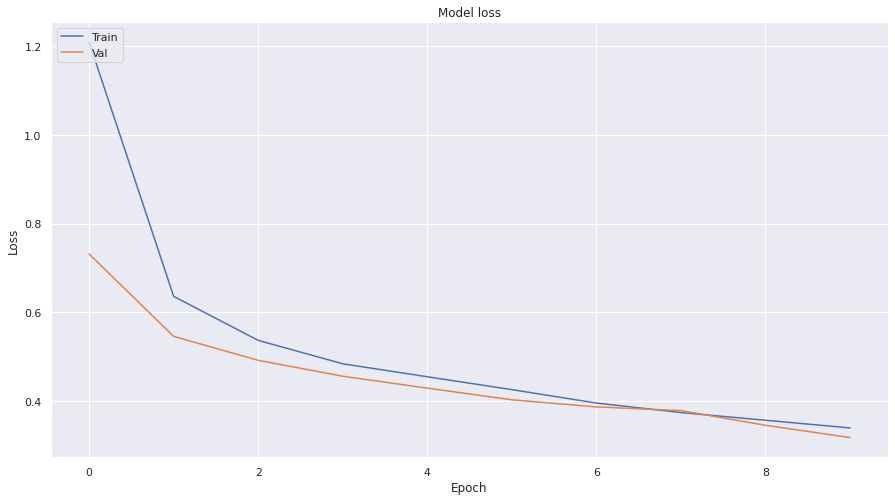

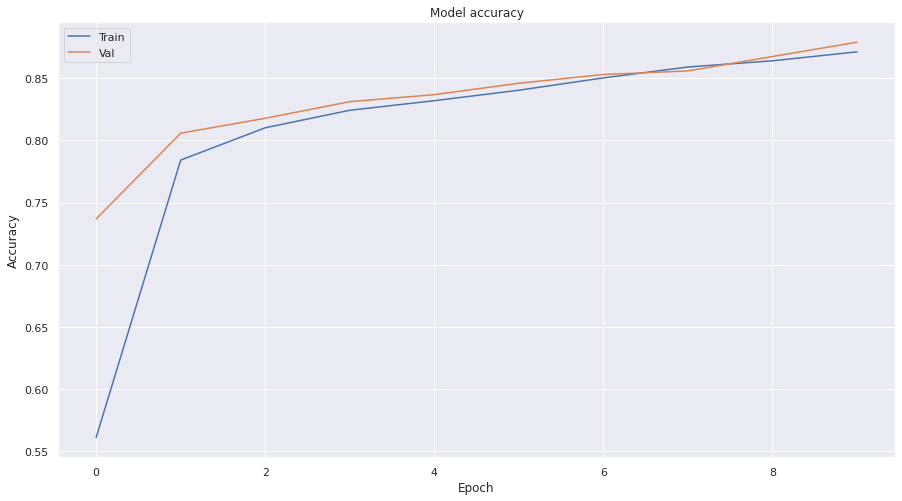

In [28]:
# we tried to plot approx the same data representation as given in the model so it can be easy to compare
# Plotting Training and Validation Accuracy and Cross-Entropy Loss against the number of Epochs 

plt.plot(np.array(history.history['loss']), label = "Train loss")
plt.plot(np.array(history.history['val_loss']), label = "Validation loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(np.array(history.history['accuracy']), label = "Train accuracy")
plt.plot(np.array(history.history['val_accuracy']), label = "Validation accuracy")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [29]:
#  Assessing the Performance of the Trained model on the Test Dataset –
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy*100,'%')
print("Test Loss :", loss*100,'%')

11/11 [==============================] - 6s 495ms/step - loss: 0.3054 - accuracy: 0.8821
Test Accuracy : 88.21117877960205 %
Test Loss : 30.54398000240326 %


##<b> Confusion Matrix</b>

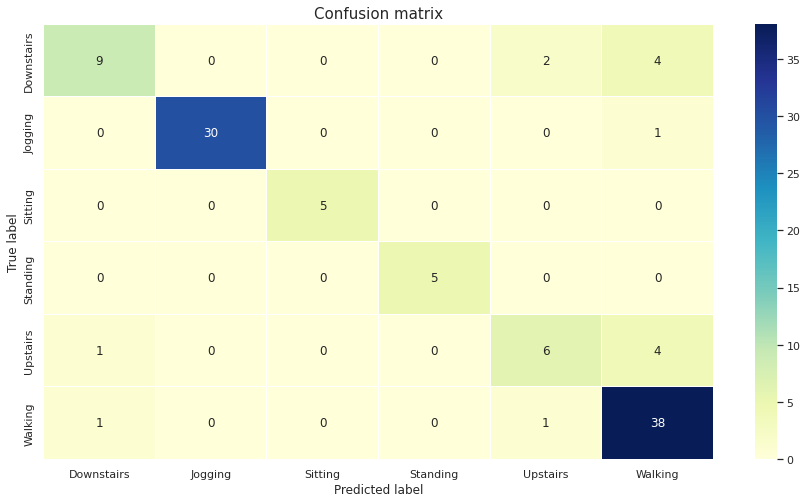

In [30]:
# Confusion Matrix
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test[:107], max_predictions[:107])
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
results = precision_recall_fscore_support(max_test, max_predictions, average='macro')

In [32]:
print(f'The Precision of the given LSTM model is: {results[0]*100} %')
print(f'\nThe Recall of the given LSTM model is: {results[1]*100} %')
print(f'\nThe F1-score of the given LSTM model is: {results[2]*100} %')

The Precision of the given LSTM model is: 84.95255641004981 %

The Recall of the given LSTM model is: 83.20364130343636 %

The F1-score of the given LSTM model is: 83.95618557318602 %


##<b> Effect of Optimizers (Own contribution )</b>

In [33]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt_adagrad = tf.keras.optimizers.Adagrad(learning_rate = 0.001)
opt_sgd = tf.keras.optimizers.SGD(learning_rate = 0.001)
opt_rmsprop = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
opt_adadelta = tf.keras.optimizers.Adadelta(learning_rate = 0.001)
opt = [opt_adam,opt_adagrad,opt_sgd,opt_rmsprop,opt_adadelta]
opt_name = ['Adam Optimizer','Adagrad Optimizer','SGD Optimizer','RMSprop Optimizer','Adadelta Optimizer', ]

In [34]:
temp = 0
history_all_optimizers = []
while temp != 5:
  print(f'\n\nThe LSTM Model is initailized with {opt_name[temp]}')
  # Preparing the LSTM Model
  X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

  # Building Model Architecture

  model = Sequential()
  # RNN layer
  model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
  # Dropout layer
  model.add(Dropout(0.5))
  # Dense layer with ReLu
  model.add(Dense(units = 64, activation='relu'))
  # Softmax layer
  model.add(Dense(y_train.shape[1], activation = 'softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=opt[temp], metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.20, batch_size = batch_size, verbose = 1)
  history_all_optimizers.append(history)
  temp += 1



The LSTM Model is initailized with Adam Optimizer
Epoch 1/5
35/35 [==============================] - 51s 1s/step - loss: 1.1862 - accuracy: 0.5842 - val_loss: 0.7345 - val_accuracy: 0.7250
Epoch 2/5
35/35 [==============================] - 49s 1s/step - loss: 0.6334 - accuracy: 0.7827 - val_loss: 0.5392 - val_accuracy: 0.8100
Epoch 3/5
35/35 [==============================] - 49s 1s/step - loss: 0.5261 - accuracy: 0.8127 - val_loss: 0.4903 - val_accuracy: 0.8218
Epoch 4/5
35/35 [==============================] - 49s 1s/step - loss: 0.4825 - accuracy: 0.8261 - val_loss: 0.4509 - val_accuracy: 0.8328
Epoch 5/5
35/35 [==============================] - 49s 1s/step - loss: 0.4625 - accuracy: 0.8305 - val_loss: 0.4854 - val_accuracy: 0.8173


The LSTM Model is initailized with Adagrad Optimizer
Epoch 1/5
35/35 [==============================] - 52s 1s/step - loss: 1.8436 - accuracy: 0.1324 - val_loss: 1.7954 - val_accuracy: 0.1918
Epoch 2/5
35/35 [==============================] - 49s 1s/s

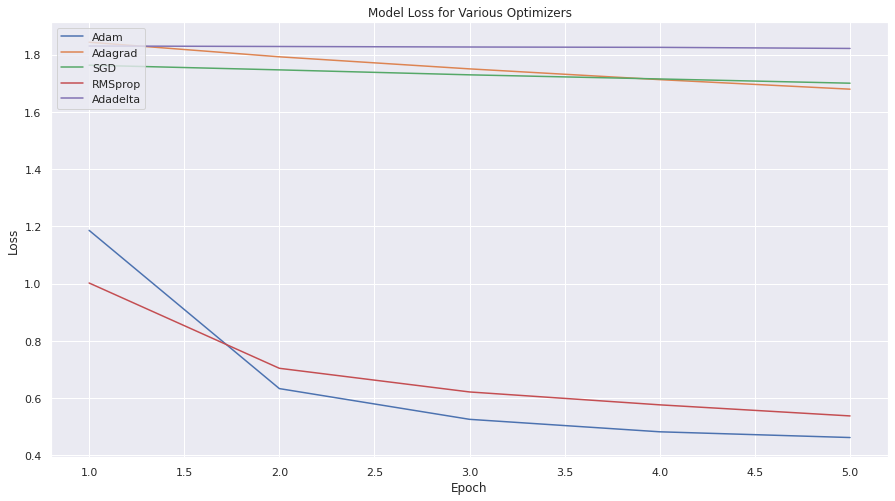

In [35]:
epochs = 5
epoch_range = range(1, epochs+1)
plt.plot(epoch_range, history_all_optimizers[0].history['loss'])
plt.plot(epoch_range, history_all_optimizers[1].history['loss'])
plt.plot(epoch_range, history_all_optimizers[2].history['loss'])
plt.plot(epoch_range, history_all_optimizers[3].history['loss'])
plt.plot(epoch_range, history_all_optimizers[4].history['loss'])
plt.title('Model Loss for Various Optimizers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Adam', 'Adagrad','SGD', 'RMSprop','Adadelta'], loc='upper left')
plt.show()